In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
#from keras.models import load_model
from PIL import Image

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("Images"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'data']


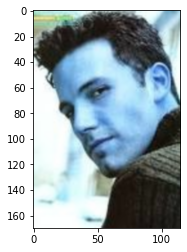

(170, 115, 3)


In [10]:
img = cv2.imread('Images/data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

2022-03-22 02:52:08.779786: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 02:52:09.219154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


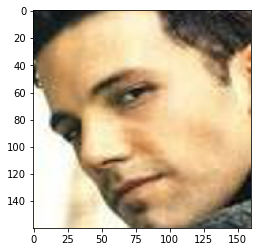

(160, 160, 3)


In [11]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('Images/data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [32]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        if subdir == ".DS_Store":
            continue
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('Images/data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('Images/data/val/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
# np.savez_compressed('5-celebrity-faces-dataset2.npz', trainX, trainy, testX, testy)
np.savez_compressed('5-celebrity-faces-dataset2.npz', X = trainX, y = trainy)

loaded 14 sample for class: ben_afflek
loaded 19 sample for class: madonna
loaded 17 sample for class: elton_john
loaded 22 sample for class: mindy_kaling
loaded 21 sample for class: jerry_seinfeld
(93, 160, 160, 3) (93,)
loaded 5 sample for class: ben_afflek
loaded 5 sample for class: madonna
loaded 5 sample for class: elton_john
loaded 5 sample for class: mindy_kaling
loaded 5 sample for class: jerry_seinfeld
(25, 160, 160, 3) (25,)


In [ ]:
# load the face dataset
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

In [ ]:
# load the facenet model
facenet_model = load_model('facenet_keras.h5')
print('Loaded Model')

In [ ]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

NameError: name 'emdTrainX' is not defined

In [ ]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

In [8]:
pip install keras==2.6.6

     |████████████████████████████████| 228 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 10.9 MB/s eta 0:00:01
  Created wheel for keras: filename=Keras-2.0.6-py3-none-any.whl size=266417 sha256=4412f69309e2052d226fedc898e8495c93c8cb55d3d44aed1d387cd2eee31203
  Stored in directory: /Users/subomipopoola/Library/Caches/pip/wheels/ca/53/82/14b166e4250a8de09b3562a5fc1d115de8489b2c2cd61d6843
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=c5430e47446c22d5b6f9222d3604c7b829a3ee9f352c072cc25049eae3f9d33e
  Stored in directory: /Users/subomipopoola/Library/Caches/pip/wheels/12/d8/36/e9b7c617ca8be398dcc48621c539d0cb1d41ff04e4367fc235
Successfully built keras theano
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

In [42]:
a ="5-celebrity-faces-dataset2.npz"
v = "/Users/subomipopoola/Documents/counterfit/counterfit/targets/satellite/satellite_images_airplane_stadium_196608.npz"
t = np.load(a, allow_pickle = True)
r = t['X'][0][0]

In [37]:
import numpy as np
import torchvision.models as models
from torchvision import transforms
from torch import nn
import torch
from torch.nn import functional as F
import PIL


In [1]:
class Subomiimg():
    target_name = "SubomiImg"
    target_data_type = "image"
    target_endpoint = f"celebriytag_weight.h5"
    target_input_shape = (3, 160, 160)
    target_output_classes = ["ben afflek", "elton john", "jerry seinfeld", "madonna", "mindy_kaling"]
    target_classifier = "BlackBox"
    sample_input_path = f"5-celebrity-faces-dataset2.npz"
    X = []
    
    def fullpath(self, v):
        return v

    def load(self):
        self.data = np.load(self.fullpath(
            self.sample_input_path), allow_pickle=True)
        self.X = self.data["X"].astype(np.float32) / 255.  # map this to [0,1]
        # Loading the pretrained resnet50 model and ready for evaluations/inference
        self.model = self._load_model()

    def get_device(self):
        return 'cpu'

    def _load_model(self):
        device = self.get_device()
        model = models.resnet50(pretrained=False).to(device)
        # A sequential container where modules will be added in the order passed to the constructor.
        # defining model using `torch.nn` package by providing number of input dimensions, hidden units, and number of outputs(`classes`)
        model.fc = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2)).to(device)
        model.load_state_dict(torch.load(self.fullpath(self.target_endpoint)))
        model.eval()
        return model

    def _apply_transformation_on_input_batch(self, x_batch):
        # Apply transformations on the data to make it suitable for predictions
        # the target model wants stack of PIL Image type for prediction
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        transformer = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize])
        x_transformed_batch = torch.stack([transformer(PIL.Image.fromarray(
            x.transpose(1, 2, 0), 'RGB')).to(self.get_device()) for x in x_batch])
        return x_transformed_batch

    def predict(self, x_batch):
        # This function takes `x_batch` as a numpy array of shape (batch, channels, H, W); apply transformations suitable for the model, and returns probability score
        # since this is an image, let's convert to uint8
        x_batch = (np.array(x_batch)*255).astype(np.uint8)  # quantize (as if saved to disk), and map to 255
        x_transformed_batch = self._apply_transformation_on_input_batch(
            x_batch)
        logps = self.model(x_transformed_batch)
        pred_probs = F.softmax(logps, dim=1).detach().numpy()
        # soften with a temperature that promotes uncertainty
        softening_temperature = 0.75
        aug_probs = pred_probs + softening_temperature
        aug_probs /= aug_probs.sum(axis=1, keepdims=True)  # renormalize rowsum to == 1
        return aug_probs.tolist()  # return a list of class probabilities

In [2]:
s = Subomiimg()

In [7]:
s.load()

UnpicklingError: invalid load key, 'H'.

In [6]:
import numpy as np
import torchvision.models as models
from torchvision import transforms
from torch import nn
import torch
from torch.nn import functional as F
import PIL

In [11]:
from functools import partial
import tensorflow

In [12]:
x = tensorflow.keras.models.load_model("save.h5")

2022-03-22 05:25:39.595911: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
x.predict_proba()

AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [15]:
x.predict_proba()

AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [ ]:
|